# ARIMA Covid-19 Model
* By Daniel Traian Pele



In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [536]:
DATE_BORDER = '2020-04-08'

data_path = Path('D:/Python/Covid-19 Forecasting/Romania/mai/')


train = pd.read_csv(data_path / 'train.csv', parse_dates=['Date'])
test = pd.read_csv(data_path /'test.csv', parse_dates=['Date'])
train['Date'] =  pd.to_datetime(train['Date'])
test['Date'] =  pd.to_datetime(test['Date'])


In [537]:
cases=train['ConfirmedCases'].dropna().values
model = pm.auto_arima(cases, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, with_intercept=False,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=466.933, BIC=468.622, Time=0.008 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=457.969, BIC=461.347, Time=0.017 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=False); AIC=455.819, BIC=459.197, Time=0.018 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=False); AIC=457.466, BIC=462.533, Time=0.029 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=False); AIC=457.455, BIC=462.522, Time=0.027 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=False); AIC=459.088, BIC=465.844, Time=0.049 seconds
Total fit time: 0.166 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -225.910
Date:                Sat, 11 Apr 2020   AIC                            455.819
Time:                        

In [538]:
# Forecast cases
n_periods = 30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.2)
# make series for plotting purpose
fc = pd.DataFrame(fc,columns = ['Prediction'])

test=test[test['Date']>train['Date'].max()].reset_index()
date=test['Date']
lower_series = pd.DataFrame(confint[:, 0],columns = ['Linf'])
upper_series = pd.DataFrame(confint[:, 1],columns = ['Lsup'])

fc=pd.concat([fc,lower_series,upper_series,date],axis=1)
fc.set_index([ 'Date'], inplace=True)
train.set_index(['Date'], inplace=True)
train=train.dropna()



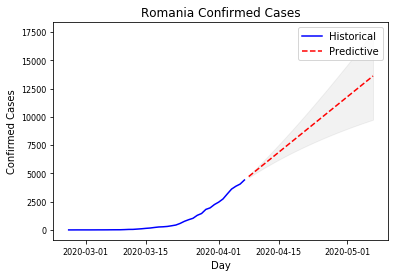

In [539]:
# Plot
plt.title('Romania Confirmed Cases')
plt.plot(train.ConfirmedCases,label='Historical',color='blue')
plt.plot(fc.Prediction,label='Predictive',color='red',linestyle='--')
plt.fill_between(fc.index, 
                 fc.Linf, 
                 fc.Lsup, 
                 color='k', alpha=.05)
plt.xlabel('Day',fontsize=10)
plt.ylabel('Confirmed Cases',fontsize=10)
plt.xticks(rotation=0,fontsize=8)
plt.yticks(fontsize=8)
plt.legend()


plt.show()


In [540]:
fc

,Prediction,Linf,Lsup
Date,,,
2020-04-08,4723.639859,4636.112459,4811.167258
2020-04-09,5030.279717,4877.825837,5182.733597
2020-04-10,5336.919576,5114.376192,5559.462959
2020-04-11,5643.559434,5344.739589,5942.379279
2020-04-12,5950.199293,5568.980786,6331.417799
2020-04-13,6256.839151,5787.360242,6726.318060
2020-04-14,6563.479010,6000.163711,7126.794308
2020-04-15,6870.118868,6207.660774,7532.576963
2020-04-16,7176.758727,6410.095575,7943.421879


In [541]:
cases=train['Fatalities'].dropna().values
model = pm.auto_arima(cases, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, with_intercept=False,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=249.476, BIC=251.165, Time=0.010 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=249.705, BIC=253.083, Time=0.013 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=False); AIC=240.985, BIC=244.363, Time=0.013 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=False); AIC=242.980, BIC=248.046, Time=0.019 seconds
Fit ARIMA: (0, 2, 2)x(0, 0, 0, 0) (constant=False); AIC=240.426, BIC=245.493, Time=0.021 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=False); AIC=239.733, BIC=246.489, Time=0.033 seconds
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=False); AIC=216.787, BIC=225.232, Time=0.062 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=False); AIC=223.360, BIC=230.116, Time=0.025 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=False); AIC=216.995, BIC=227.128, Time=0.088 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=False); AIC=216.893, BIC=227.027, Time=0

In [542]:
# Forecast Fatalities
n_periods = 30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.2)
# make series for plotting purpose
fc = pd.DataFrame(fc,columns = ['Prediction'])

lower_series = pd.DataFrame(confint[:, 0],columns = ['Linf'])
upper_series = pd.DataFrame(confint[:, 1],columns = ['Lsup'])

fc=pd.concat([fc,lower_series,upper_series,date],axis=1)
fc.set_index([ 'Date'], inplace=True)


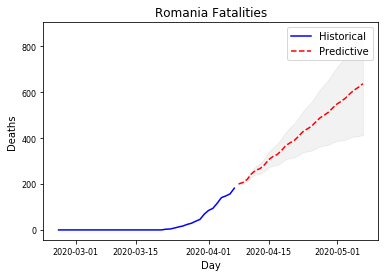

In [543]:
# Plot
plt.title('Romania Fatalities')
plt.plot(train.Fatalities,label='Historical',color='blue')
plt.plot(fc.Prediction,label='Predictive',color='red',linestyle='--')
plt.fill_between(fc.index, 
                 fc.Linf, 
                 fc.Lsup, 
                 color='k', alpha=.05)
plt.xlabel('Day',fontsize=10)
plt.ylabel('Deaths',fontsize=10)
plt.xticks(rotation=0,fontsize=8)
plt.yticks(fontsize=8)
plt.legend()


plt.show()